In [403]:
import pandas as pd
import numpy as np
import dill
import torch.nn as nn
import torch
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import os
import random
import copy
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import confusion_matrix
from collections import defaultdict, Counter
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.optimizer import required
from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.utils import class_weight
sns.set_theme(style="whitegrid")

In [404]:
bkdatafolder = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/BKDataCleaned/"

In [430]:
def createDictFloor(floor_idx,path):
    floorname = f'Floor{floor_idx}'
    fulldata = os.listdir(path)
    getdict = {}
    floors = [floor for floor in fulldata if floorname in floor]
    for name in floors:
        floor_zone = name.split(".")[0]
        getdict[floor_zone] = pd.read_csv(path+name, index_col=0, parse_dates=["Date"])
        getdict[floor_zone] = getdict[floor_zone].sort_index()
    return getdict

def Missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Pourcentage'])
    print (missing_data[(percent>0)],'\n' )

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
def createDTFeat(date1, date2, datadict, featureX, featureY, resample_method_X="mean", resample_method_Y = "sum" ,scale=True):
    resample_move = {}
    index_nan = {}
    index_small = {}
    floors = list(datadict.keys())
    dates = []
    scalers = {}
    for floorname in datadict.keys():
        dataX = datadict[floorname][date1:date2][featureX].copy()
        dataY = datadict[floorname][date1:date2][featureY].copy()
        
        if resample_method_X == "sum":
            dataX = dataX.resample("5T").sum()
            
        elif resample_method_X == "mean":
            dataX = dataX.resample("5T").mean().bfill()
        else:
            pass
        
        if resample_method_Y =="sum":
            dataY = dataY.resample("5T").sum()
        elif resample_method_Y == "mean":
            dataY = dataY.resample("5T").mean().bfill()
        else:
            pass
        
        resample_move[floorname] = pd.concat([dataX, dataY],axis=1)
        resample_move[floorname]["date"] = resample_move[floorname].index.date
        resample_move[floorname]["date"] = resample_move[floorname]["date"].apply(lambda x: x.strftime("%Y-%m-%d"))
    for date in resample_move[floors[0]]["date"]:
        dates.append(str(date))
    dates = sorted(set(dates))
            
    return resample_move, dates
            
        #mysample[data] = resample_move[data].copy()
           
def data_scaling(datadict, feature):
    scalers = {}
    scaled_data_dict = datadict.copy()
    for floorname in datadict.keys():
        cols = datadict[floorname][feature].columns
        idx = datadict[floorname][feature].index
        scaler = MinMaxScaler(feature_range=(0,1))
        scaler.fit(datadict[floorname][feature])
        scaled_data_dict[floorname][feature] = pd.DataFrame(scaler.transform(
                                                datadict[floorname][feature]),columns=cols,index=idx)
        scalers[data] = scaler

    return scaled_data_dict

def getInfoTimeShape(datadict):
    for floor in datadict.keys():
        data = datadict[floor]
        print("Floor : {} , shape :{} , TimeMin {} , TimeMax {}".format(floor,data.shape, data.index.min(), data.index.max()))
        Missing_values(data)
        
def cleanNan(data,idx_nan):
    index=[]
    for k,v in idx_nan.items():
        for ele in v:
            index.append(ele)
    mynan = set(index)
    newdata = data.copy()
    remain_date = []
    for floor in idx_nan.keys():
        datafloor = data[floor]
        todropnan = datafloor[datafloor["date"].isin(list(mynan))].index
        datafloor = datafloor.drop(todropnan)
        newdata[floor] = datafloor
        for date in datafloor["date"]:
            remain_date.append(str(date))
    remain_date = sorted(set(remain_date))
    return data, remain_date

In [431]:
def create_power_class(data_dict, conditions, feature):
    keys = sorted(list(data_dict.keys()))
    classes = list(conditions[keys[0]].keys())
    new_datadict = data_dict.copy()
    for floor_name in keys:
        data_dict[floor_name]["ACPowerClass"] = pd.Series(dtype='object')
        for p_class in classes:
            idx_classes = data_dict[floor_name].loc[(data_dict[floor_name][feature] >= conditions[floor_name][p_class][0]) &
                                         (data_dict[floor_name][feature] <= conditions[floor_name][p_class][1])]
            new_datadict[floor_name]["ACPowerClass"].loc[idx_classes.index] = new_datadict[floor_name]["ACPowerClass"].loc[idx_classes.index].apply(lambda x: p_class)
    return new_datadict

In [432]:
date1 = "2019-03-07"
date2 = "2019-12-31"
floor = 7
floor_dict = createDictFloor(floor, bkdatafolder)
for data in floor_dict.keys():
    zone = floor_dict[data]
    print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
    print("")

Floor7Z4 Start: 2019-03-06 14:46:00 End: 2019-12-31 23:59:00 Count:416243

Floor7Z5 Start: 2019-03-06 14:55:00 End: 2019-12-31 23:59:00 Count:407698

Floor7Z2 Start: 2019-03-06 14:48:00 End: 2019-12-31 23:59:00 Count:424701

Floor7Z1 Start: 2019-03-06 14:50:00 End: 2019-12-31 23:59:00 Count:424099



Floor7Z1
Floor7Z2
Floor7Z4
Floor7Z5


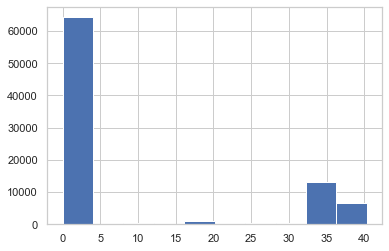

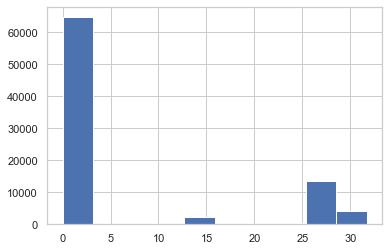

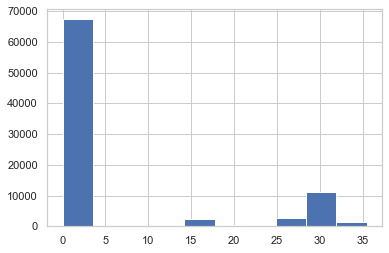

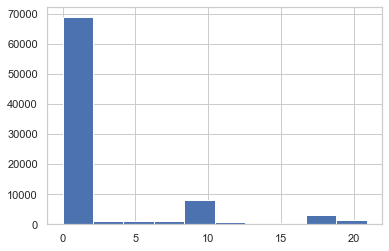

In [424]:
for floor in sorted(resample_data.keys()):
    plt.figure()
    print(floor)
    plt.hist(resample_data[floor]["ACPower"])

In [425]:
set_point = {"Floor7Z1":{"Low Power":[0,30],
                        "High Power":[30,100]},
            "Floor7Z2":{"Low Power":[0,25],
                       "High Power":[25,100]},
            "Floor7Z4":{"Low Power":[0,25],
                       "High Power":[25,100]},
            "Floor7Z5":{"Low Power":[0,15],
                       "High Power":[15,100]}}

In [426]:
def rolling_window(series, window_size, stride=1):
    return np.array([series[i : (i + window_size)] for i in range(0, series.shape[0] - window_size + 1, stride)])

def to_timeseries_input(series, lookback, predictions):
    inputs = rolling_window(series[:-predictions], lookback)
    outputs = rolling_window(series[lookback:], predictions)
    return inputs, outputs

def createDataByDate(datadict, features, dates):
    databyDate = defaultdict(lambda : defaultdict(dict))
    for date in dates:
        for floor in datadict.keys():
            databyDate[date][floor] = np.asarray(datadict[floor][date][features])
    return databyDate

def splitDate(dates,cutoff):
    train_date = [x for x in dates if x <= cutoff]
    test_date = sorted(list(set(dates) - set(train_date)))
    return train_date, test_date

def LoaderByZoneXY(dataX, dataY, zone_name,dates, seq_len, batch_size, shuffle=False):
    loaderZ = {}
    encode = {"Low Power": 0, "High Power": 1}
    #mid, high, low = 0., 0., 0.
    for i,date in enumerate(dates):
        trainx = rolling_window(dataX[date][zone_name], seq_len)
        trainy = rolling_window(dataY[date][zone_name], seq_len)
        to_class_y = torch.zeros((trainy.shape[0])) #[0.]*trainy.shape[0]
        mid, high, low = 0., 0., 0.
        for idx_y in range(trainy.shape[0]):
            selected = select_impact_powerclass(trainy[idx_y])
            if selected == "High Power":
                high += 1
            #elif selected == "Mid Power":
            #    mid += 1
            elif selected == "Low Power":
                low += 1
            to_class_y[idx_y] = encode[selected]
            #print(f'Chosen class {selected} Encode {to_class_y[idx_y]}')
        print(f'Low count {low} High count {high}')
        xshape = torch.tensor(trainx, dtype=torch.float)
        yshape = torch.tensor(to_class_y, dtype=torch.long)
        #print(xshape.shape, yshape.shape)
        tensorwrap = TensorDataset(xshape,yshape)
        loaderxy = DataLoader(tensorwrap,batch_size = batch_size, shuffle=shuffle, drop_last=True)
        loaderZ[date] = loaderxy
    return loaderZ

def select_impact_powerclass(y):
    rev_dict = defaultdict(list)
    ct = Counter(y)
    for k,v in ct.items():
        rev_dict[v].append(k)
    list_class = list(rev_dict.keys())
    if len(list_class) == 1:
        key = list_class[0]
        return rev_dict[key][0] 
    else:
        key = max(list_class)
        if len(rev_dict[key]) == 1:
            return rev_dict[key][0]
        elif len(rev_dict[key]) > 1:
            #if "Mid Power" in rev_dict[key]:
            #    return "Mid Power"
            if "High Power" in rev_dict[key]:
                return "High Power"
            else:
                return "Low Power"

In [435]:
featureX = ["temperature"]
featureY = "ACPower"
resample_methodX = "mean"
resample_methodY = "mean"
resample_data, remain_date = createDTFeat(date1, date2, floor_dict, featureX, featureY,resample_method_X=resample_methodX, resample_method_Y=resample_methodY)
resample_data_classes = create_power_class(resample_data, set_point, "ACPower")
scaled_data = data_scaling(resample_data_classes, featureX)

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [436]:
resample_data["Floor7Z1"]

,temperature,ACPower,date,ACPowerClass
Date,,,,
2019-03-07 00:00:00,0.549332,0.02,2019-03-07,Low Power
2019-03-07 00:05:00,0.549220,0.02,2019-03-07,Low Power
2019-03-07 00:10:00,0.548886,0.02,2019-03-07,Low Power
2019-03-07 00:15:00,0.549777,0.02,2019-03-07,Low Power
2019-03-07 00:20:00,0.550557,0.02,2019-03-07,Low Power
...,...,...,...,...
2019-12-31 23:35:00,0.682071,0.01,2019-12-31,Low Power
2019-12-31 23:40:00,0.682071,0.01,2019-12-31,Low Power
2019-12-31 23:45:00,0.681960,0.01,2019-12-31,Low Power


In [437]:
Counter(resample_data_classes['Floor7Z2']["ACPowerClass"])

Counter({'Low Power': 68334, 'High Power': 18066})

In [438]:
cutting_date = "2019-05-08"
train_date, test_date = splitDate(remain_date, cutting_date)
databyDateX = createDataByDate(scaled_data, featureX, remain_date)
databyDateY = createDataByDate(scaled_data, "ACPowerClass", remain_date)

/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_3088/903661539.py:13: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  databyDate[date][floor] = np.asarray(datadict[floor][date][features])


In [445]:
def smote_by_floor(datadict, dates,smote=True):
    floors = list(datadict.keys())
    datasynth = {}
    smotedata = {}
    for floor in floors:
        select_date = datadict[floor].loc[datadict[floor].apply(lambda x: x.date in dates, axis=1)]
        #print(f"-----{floor}-----")
        #print(f'Original Data {Counter(select_date["ACPowerClass"])}')
        ada = ADASYN(sampling_strategy='not majority', n_neighbors=7)
        datax = select_date[["temperature", "ACPower"]]
        datay = select_date["ACPowerClass"]
        if smote:
            ada = ADASYN(sampling_strategy='not majority', n_neighbors=7)
            resample = ada.fit_resample(datax, datay)
            smotedata[floor] = pd.concat(resample, axis=1)
            #print(f'Smote Data {Counter(smotedata[floor]["ACPowerClass"])}')
        smotedata[floor] = class_weight.compute_class_weight('balanced', ["Low Power","High Power"], np.array(datay))
    return smotedata

In [178]:
weights = smote_by_floor(scaled_data, train_date, smote=False)

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=['Low Power', 'Mid Power', 'High Power'], y=['Low Power' 'Low Power' 'Low Power' ... 'Low Power' 'Low Power'
 'Low Power'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=['Low Power', 'Mid Power', 'High Power'], y=['Low Power' 'Low Power' 'Low Power' ... 'Low Power' 'Low Power'
 'Low Power'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=['Low Power

In [182]:
torch.tensor(weights['Floor7Z1'])

tensor([ 0.4558, 28.3944,  1.2976], dtype=torch.float64)

In [440]:
batch_size = 32
seq_len = 13
nb_zone = 5
trainloader = []
testloader = []
for zone in range(1,nb_zone+1):
    if zone != 3:
        zoneID = f"Floor{floor}Z{zone}"
        print(f'-----{zoneID}-----')
        loaderZtrain = LoaderByZoneXY(databyDateX, databyDateY, zoneID, train_date,seq_len,batch_size, shuffle=True)
        loaderZtest = LoaderByZoneXY(databyDateX, databyDateY, zoneID, test_date,seq_len,batch_size, shuffle=False)
        trainloader.append(loaderZtrain)
        testloader.append(loaderZtest)
zone_no=len(trainloader)

-----Floor7Z1-----
 Mid count 0.0 Low count 186.0 High count 90.0
 Mid count 0.0 Low count 188.0 High count 88.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 185.0 High count 91.0


/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_3088/903661539.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yshape = torch.tensor(to_class_y, dtype=torch.long)


 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 165.0 High count 111.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 195.0 High count 81.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low c

 Mid count 0.0 Low count 182.0 High count 94.0
 Mid count 0.0 Low count 181.0 High count 95.0
 Mid count 0.0 Low count 168.0 High count 108.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 182.0 High count 94.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 183.0 High count 93.0
 Mid count 0.0 Low count 182.0 High count 94.0
 Mid count 0.0 Low count 201.0 High count 75.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 182.0 High count 94.0
 Mid count 0.0 Low count 182.0 High count 94.0
 Mid count 0.0 Low count 185.0 High count 91.0
 Mid count 0.0 Low count 183.0 High count 93.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 229.0 High count 47.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 182.0 High count 94.0
 Mid count 0.0 Low count 182.0 High count 94.0
 Mid count 0.0 Low

 Mid count 0.0 Low count 196.0 High count 80.0
 Mid count 0.0 Low count 265.0 High count 11.0
 Mid count 0.0 Low count 274.0 High count 2.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 186.0 High count 90.0
 Mid count 0.0 Low count 185.0 High count 91.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low count 183.0 High count 93.0
 Mid count 0.0 Low count 203.0 High count 73.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 184.0 High count 92.0
 Mid count 0.0 Low cou

 Mid count 0.0 Low count 224.0 High count 52.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 214.0 High count 62.0
 Mid count 0.0 Low count 268.0 High count 8.0
 Mid count 0.0 Low count 254.0 High count 22.0
 Mid count 0.0 Low count 249.0 High count 27.0
 Mid count 0.0 Low count 265.0 High count 11.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 258.0 High count 18.0
 Mid count 0.0 Low count 276.0 High count 0.0
 Mid count 0.0 Low count 270.0 High count 6.0
 Mid count 0.0 Low count 242.0 High count 34.0
 Mid count 0.0 Low count 27

In [441]:
nb_iterations = len(train_date)*len(trainloader[0]["2019-03-08"])
nb_iterations

504

# Algorithm 

In [442]:
import sys
sys.path.append('../src/')

In [443]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

In [444]:
from algoaux import *
from optimizerDMFW import *
#from trainer import *
from graphs import *

In [176]:
class CNN1D(nn.Module):
    def __init__(self,nb_chan_out, nb_classes, input_len,kernel_size):
        super(CNN1D, self).__init__()
        
        #self.output_chan = 
        #self.output_len = output_l
        self.input_len = input_len
        
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=nb_chan_out, kernel_size=kernel_size, stride=1, 
                                padding=int(np.floor(kernel_size/2)))
        
        
        self.maxpool = nn.MaxPool1d(3)
        self.batchnorm = nn.BatchNorm1d(nb_chan_out)
        self.fc1 = nn.Linear(nb_chan_out*int((input_len/3)),nb_classes, bias=True)
        #self.fc2 = nn.Linear(16, nb_classes, bias=True)
        
    def forward(self, x):
        inputs = x.permute(0,2,1)
        #print(inputs.shape)
        out = self.conv1d(inputs)
        out = self.batchnorm(out)
        #print(out.shape)
        out = self.maxpool(out)
        #print(out.shape)
        out = nn.LeakyReLU()(out)
        
        out = out.view(-1, out.shape[1]*out.shape[2])
        
        out = self.fc1(out)
        #out = nn.LeakyReLU()(out)
        #out = self.fc2(out)
        return out

In [207]:
class Trainer:
    def __init__(self, graph, loaders, model, model_param, loss,
                 num_iterations):
        self.graph = graph
        self.num_nodes = graph.number_of_nodes()
        self.model = model
        self.param = model_param
        self.A = torch.tensor(nx.adjacency_matrix(graph).toarray())
        self.dataloader = loaders
        self.num_iterations = num_iterations
        self.loss = loss
        self.obj_values = np.ndarray((self.num_iterations + 1, 4),
                                     dtype='float')

        self.optimizers = [0.] * self.num_nodes
        self.models = [0.] * self.num_nodes
        self.losses = [0.] * self.num_nodes
        self.class_weights = weights
        #self.gaps = [0.]*self.num_nodes

    def reset(self):
        self.optimizers = [0.] * self.num_nodes
        self.models = [0.] * self.num_nodes
        self.losses = [0.] * self.num_nodes
        self.gaps = [0.] * self.num_nodes
        self.best_models = [0.]*self.num_nodes
        self.acc = [0.]*self.num_nodes
        self.f1 = [0.]*self.num_nodes
        self.loss_function = [self.loss(weight = torch.tensor(weights["Floor7Z1"], dtype=torch.float)),
                             self.loss(weight = torch.tensor(weights["Floor7Z2"], dtype=torch.float)),
                             self.loss(weight = torch.tensor(weights["Floor7Z4"], dtype=torch.float)),
                             self.loss(weight = torch.tensor(weights['Floor7Z5'], dtype=torch.float))]

        self.obj_values = np.ndarray((self.num_iterations + 1, 7),
                                     dtype='float')
        
    def __nodeInit(self, data, label):
        nodewrap = TensorDataset(data, label)
        nodes = DataLoader(nodewrap, batch_size=data.size(0), shuffle=False)
        return nodes

    def weight_reset(self, layer):
        if isinstance(layer, nn.BatchNorm1d) or isinstance(layer, nn.Linear) or isinstance(layer,nn.Conv1d):
            layer.reset_parameters()
            
    def initModelWeight(self, model):
        for name,param in model.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param,0.)
            elif 'weight' in name:
                if not 'batch' in name:
                    nn.init.xavier_normal_(param)
                else:
                    nn.init.uniform_(param)

    def saveCheckPts(self, t, path):
        check_pts = {}
        for i in range(self.num_nodes):
            ckp_i = {
                "t": t,
                "weight": [param for param in self.models[i].parameters()],
                "optimizer_weight": self.optimizers[i].w_dict,
                "oracles": self.optimizers[i].G,
                "loss": self.losses[i]
            }  #,
            #"avg_loss": self.avg_loss[i]}
            check_pts[i] = ckp_i
        torch.save(check_pts, path + "checkpts_models" + "_" + str(t) + ".tar")
        
    def plotPrediction(self, true, pred,date,path_to_save):
        fig = plt.figure(figsize=(5,3))
        plt.suptitle("{}".format(date))
        plt.plot(true)
        plt.plot(pred)
        #plt.show()
        fig.savefig(os.path.join(path_to_save,date))
        plt.close()

    def train(self, optimizer, L, eta_coef, eta_exp, reg_coef, radius, path_figure_date):
        seed_everything()
        self.reset()

        days= list(self.dataloader[0].keys())

        for i in range(self.num_nodes):
            self.models[i] = self.model(*self.param)
            self.optimizers[i] = optimizer(self.models[i].parameters(),
                                           eta_coef=eta_coef,
                                           eta_exp=eta_exp,
                                           L=L,
                                           matrix_line=self.A[i],
                                           reg_coef=reg_coef,
                                           radius=radius)
            self.best_models[i] = copy.deepcopy(self.models[i])

        self.final_gap = [0.] * self.num_nodes
        
        t = 0
        
        for date in days:
            acc_node = [0.]*self.num_nodes
            f1_node = [0.]*self.num_nodes
            prec_node = [0.]*self.num_nodes
            rec_node = [0.]*self.num_nodes
            for i,loader in enumerate(self.dataloader):
                acc_node[i], f1_node[i], prec_node[i], rec_node[i]  = ModelPrediction(self.best_models[i], date, loader)
                #if len(truez)==0 or len(predz)==0 : continue
            acc = np.mean(acc_node)
            f1  = np.mean(f1_node)
            prec = np.mean(prec_node)
            rec = np.mean(rec_node)


            z1, z2, z4, z5  = self.dataloader

            for (couple1, couple2, couple4, couple5) in zip(z1[date],z2[date], z4[date], z5[date]):
                datazones = [self.__nodeInit(*couple1), 
                             self.__nodeInit(*couple2),
                             self.__nodeInit(*couple4),
                             self.__nodeInit(*couple5)]

                for i in range(self.num_nodes):
                    self.initModelWeight(self.models[i])
                    self.models[i].train()


                    def closure():
                        self.optimizers[i].zero_grad(set_to_none=True)
                        x, y = iter(datazones[i]).next()
                        output = self.models[i](x)
                        loss = self.loss_function[i](output,y)
                        loss.backward()

                    self.optimizers[i].initValue(closure)
                # import pdb; pdb.set_trace()

                opt_index = np.random.randint(low=0,high=L, size=1)


                for l in range(L):
                    #print("--------------------------")

                    if l==opt_index:
                        for i in range(self.num_nodes):
                            self.best_models[i] = copy.deepcopy(self.models[i])


                    for i in range(self.num_nodes):
                        self.optimizers[i].neighborsAverage(self.optimizers)
                        
                    for i in range(self.num_nodes):
                        
                        def closure():
                            self.optimizers[i].zero_grad(set_to_none=True)
                            x, y = iter(datazones[i]).next()
                            output = self.models[i](x)
                            loss = self.loss_function[i](output, y)
                            loss.backward()
                            
                        self.optimizers[i].step(l, closure)

                self.gaps_off = [0.] * self.num_nodes
                for i in range(self.num_nodes):
                    total = 0.
                    correct = 0.
                    with torch.no_grad():
                        self.models[i].eval()
                        x, y = iter(datazones[i]).next()
                        outputs = self.best_models[i](x)
                        curr_loss = self.loss_function[i](outputs, y)
                        
                        _, predicted = torch.max(outputs,1)
                        total += y.size(0)
                        correct += (predicted == y).sum().item()
                        
                        true, pred = y.detach().numpy(), predicted.detach().numpy()
                    #self.acc[i] = correct/total
                    #self.f1[i] = f1_score(true, pred, average='weighted')
                    self.final_gap[i] += self.optimizers[i].init_gap
                    self.final_gap[i] /= (t + 1)
                    self.gaps_off[i] = self.optimizers[i].init_gap
                    self.losses[i] = curr_loss.detach().numpy()

                loss = np.mean(self.losses)
                #acc = np.mean(self.acc)
                #f1 = np.mean(self.f1)
                gap = np.max(self.final_gap)  #.detach().numpy(
                local_gap = np.max(self.gaps_off)
                if t % 1 == 0:
                    print("t_{} : loss : {:.5f} gap : {:.5f} acc {:.5f} f1 {:.5f} precision {:.5f} recall {:.5f}".format(
                        t, loss, gap, acc, f1, prec, rec))
                    #print(f't : {t} acc : {acc} f1 : {f1} prec : {prec} recall : {recall}')
                try:
                    self.obj_values[t, :] = [t, loss, gap, acc, f1, prec, rec]
                except:
                    print ("problem in Training Process... Skipping for debug...")
                    # import pdb; pdb.set_trace()
                    
                t+=1
        return self.obj_values

In [208]:
loss_fn = nn.CrossEntropyLoss
num_iters_base = nb_iterations
eta_coef_DMFW = 1
eta_exp_DMFW = 0.75
rho_coef_DMFW = 4e-0
rho_exp_DMFW = 1/2
reg_coef_DMFW = 10
L_DMFW = nb_iterations

In [209]:
complet ,_ = completegraph(4)
cycle, _ = cycle_graph(4)
grid, _ = gridgraph(2,2)
line, _ = gridgraph(4,1)

In [210]:
trainXMFW = Trainer(cycle,trainloader,CNN1D, (8,3,seq_len,3), loss_fn,num_iters_base)

In [211]:
values_dmfw = trainXMFW.train(DMFW, L_DMFW, eta_coef_DMFW, eta_exp_DMFW, reg_coef_DMFW,1,
                            path_figure_date=None)

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/

t_0 : loss : 1.09685 gap : 0.00559 acc 0.13867 f1 0.10740 precision 0.19897 recall 0.13867
t_1 : loss : 0.72449 gap : 0.00347 acc 0.13867 f1 0.10740 precision 0.19897 recall 0.13867
t_2 : loss : 0.72471 gap : 0.00150 acc 0.13867 f1 0.10740 precision 0.19897 recall 0.13867
t_3 : loss : 0.76719 gap : 0.00124 acc 0.13867 f1 0.10740 precision 0.19897 recall 0.13867
t_4 : loss : 0.90252 gap : 0.00128 acc 0.13867 f1 0.10740 precision 0.19897 recall 0.13867
t_5 : loss : 0.80180 gap : 0.00206 acc 0.13867 f1 0.10740 precision 0.19897 recall 0.13867
t_6 : loss : 0.83625 gap : 0.00093 acc 0.13867 f1 0.10740 precision 0.19897 recall 0.13867
t_7 : loss : 0.86619 gap : 0.00105 acc 0.13867 f1 0.10740 precision 0.19897 recall 0.13867


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_8 : loss : 0.75840 gap : 0.00100 acc 0.85254 f1 0.84817 precision 0.84597 recall 0.85254
t_9 : loss : 1.07739 gap : 0.00050 acc 0.85254 f1 0.84817 precision 0.84597 recall 0.85254
t_10 : loss : 0.91413 gap : 0.00060 acc 0.85254 f1 0.84817 precision 0.84597 recall 0.85254
t_11 : loss : 0.83838 gap : 0.00040 acc 0.85254 f1 0.84817 precision 0.84597 recall 0.85254
t_12 : loss : 0.69033 gap : 0.00021 acc 0.85254 f1 0.84817 precision 0.84597 recall 0.85254
t_13 : loss : 0.79174 gap : 0.00025 acc 0.85254 f1 0.84817 precision 0.84597 recall 0.85254
t_14 : loss : 0.73467 gap : 0.00022 acc 0.85254 f1 0.84817 precision 0.84597 recall 0.85254
t_15 : loss : 0.64205 gap : 0.00019 acc 0.85254 f1 0.84817 precision 0.84597 recall 0.85254
t_16 : loss : 0.44993 gap : 0.00024 acc 1.00000 f1 1.00000 precision 1.00000 recall 1.00000
t_17 : loss : 0.23521 gap : 0.00008 acc 1.00000 f1 1.00000 precision 1.00000 recall 1.00000
t_18 : loss : 0.22084 gap : 0.00003 acc 1.00000 f1 1.00000 precision 1.00000 recal

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforg

t_32 : loss : 1.90146 gap : 0.00268 acc 0.65625 f1 0.52009 precision 0.43076 recall 0.65625
t_33 : loss : 0.94736 gap : 0.00025 acc 0.65625 f1 0.52009 precision 0.43076 recall 0.65625
t_34 : loss : 0.76757 gap : 0.00009 acc 0.65625 f1 0.52009 precision 0.43076 recall 0.65625
t_35 : loss : 0.72839 gap : 0.00010 acc 0.65625 f1 0.52009 precision 0.43076 recall 0.65625
t_36 : loss : 0.71984 gap : 0.00007 acc 0.65625 f1 0.52009 precision 0.43076 recall 0.65625
t_37 : loss : 0.70570 gap : 0.00015 acc 0.65625 f1 0.52009 precision 0.43076 recall 0.65625
t_38 : loss : 0.66298 gap : 0.00006 acc 0.65625 f1 0.52009 precision 0.43076 recall 0.65625
t_39 : loss : 0.63808 gap : 0.00011 acc 0.65625 f1 0.52009 precision 0.43076 recall 0.65625


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_40 : loss : 0.66865 gap : 0.00006 acc 0.87012 f1 0.85099 precision 0.84262 recall 0.87012
t_41 : loss : 0.72083 gap : 0.00007 acc 0.87012 f1 0.85099 precision 0.84262 recall 0.87012
t_42 : loss : 0.81659 gap : 0.00012 acc 0.87012 f1 0.85099 precision 0.84262 recall 0.87012
t_43 : loss : 0.74079 gap : 0.00007 acc 0.87012 f1 0.85099 precision 0.84262 recall 0.87012
t_44 : loss : 0.70316 gap : 0.00002 acc 0.87012 f1 0.85099 precision 0.84262 recall 0.87012
t_45 : loss : 0.67924 gap : 0.00003 acc 0.87012 f1 0.85099 precision 0.84262 recall 0.87012
t_46 : loss : 0.62270 gap : 0.00005 acc 0.87012 f1 0.85099 precision 0.84262 recall 0.87012
t_47 : loss : 0.74004 gap : 0.00006 acc 0.87012 f1 0.85099 precision 0.84262 recall 0.87012


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_48 : loss : 0.82296 gap : 0.00018 acc 0.81348 f1 0.78069 precision 0.76019 recall 0.81348
t_49 : loss : 0.77996 gap : 0.00013 acc 0.81348 f1 0.78069 precision 0.76019 recall 0.81348
t_50 : loss : 0.74817 gap : 0.00005 acc 0.81348 f1 0.78069 precision 0.76019 recall 0.81348
t_51 : loss : 0.78591 gap : 0.00008 acc 0.81348 f1 0.78069 precision 0.76019 recall 0.81348
t_52 : loss : 0.78212 gap : 0.00005 acc 0.81348 f1 0.78069 precision 0.76019 recall 0.81348
t_53 : loss : 0.74220 gap : 0.00009 acc 0.81348 f1 0.78069 precision 0.76019 recall 0.81348
t_54 : loss : 0.69980 gap : 0.00008 acc 0.81348 f1 0.78069 precision 0.76019 recall 0.81348
t_55 : loss : 0.72779 gap : 0.00007 acc 0.81348 f1 0.78069 precision 0.76019 recall 0.81348


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_56 : loss : 0.71445 gap : 0.00007 acc 0.78613 f1 0.80012 precision 0.94081 recall 0.78613
t_57 : loss : 0.73414 gap : 0.00005 acc 0.78613 f1 0.80012 precision 0.94081 recall 0.78613
t_58 : loss : 0.78171 gap : 0.00006 acc 0.78613 f1 0.80012 precision 0.94081 recall 0.78613
t_59 : loss : 0.77280 gap : 0.00004 acc 0.78613 f1 0.80012 precision 0.94081 recall 0.78613
t_60 : loss : 0.71968 gap : 0.00005 acc 0.78613 f1 0.80012 precision 0.94081 recall 0.78613
t_61 : loss : 0.75159 gap : 0.00004 acc 0.78613 f1 0.80012 precision 0.94081 recall 0.78613
t_62 : loss : 0.72129 gap : 0.00005 acc 0.78613 f1 0.80012 precision 0.94081 recall 0.78613
t_63 : loss : 0.76073 gap : 0.00006 acc 0.78613 f1 0.80012 precision 0.94081 recall 0.78613


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/

t_64 : loss : 0.77105 gap : 0.00010 acc 0.78027 f1 0.78329 precision 0.78716 recall 0.78027
t_65 : loss : 0.70323 gap : 0.00006 acc 0.78027 f1 0.78329 precision 0.78716 recall 0.78027
t_66 : loss : 0.85222 gap : 0.00009 acc 0.78027 f1 0.78329 precision 0.78716 recall 0.78027
t_67 : loss : 0.76768 gap : 0.00004 acc 0.78027 f1 0.78329 precision 0.78716 recall 0.78027
t_68 : loss : 0.73833 gap : 0.00009 acc 0.78027 f1 0.78329 precision 0.78716 recall 0.78027
t_69 : loss : 0.75770 gap : 0.00007 acc 0.78027 f1 0.78329 precision 0.78716 recall 0.78027
t_70 : loss : 0.72488 gap : 0.00005 acc 0.78027 f1 0.78329 precision 0.78716 recall 0.78027
t_71 : loss : 0.67865 gap : 0.00005 acc 0.78027 f1 0.78329 precision 0.78716 recall 0.78027
t_72 : loss : 0.40236 gap : 0.00015 acc 1.00000 f1 1.00000 precision 1.00000 recall 1.00000
t_73 : loss : 0.08943 gap : 0.00001 acc 1.00000 f1 1.00000 precision 1.00000 recall 1.00000
t_74 : loss : 0.12768 gap : 0.00000 acc 1.00000 f1 1.00000 precision 1.00000 rec

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_88 : loss : 1.43980 gap : 0.00036 acc 0.66504 f1 0.55025 precision 0.53286 recall 0.66504
t_89 : loss : 1.66345 gap : 0.00038 acc 0.66504 f1 0.55025 precision 0.53286 recall 0.66504
t_90 : loss : 0.86646 gap : 0.00018 acc 0.66504 f1 0.55025 precision 0.53286 recall 0.66504
t_91 : loss : 1.28121 gap : 0.00026 acc 0.66504 f1 0.55025 precision 0.53286 recall 0.66504
t_92 : loss : 0.83173 gap : 0.00011 acc 0.66504 f1 0.55025 precision 0.53286 recall 0.66504
t_93 : loss : 0.85868 gap : 0.00005 acc 0.66504 f1 0.55025 precision 0.53286 recall 0.66504
t_94 : loss : 0.79336 gap : 0.00002 acc 0.66504 f1 0.55025 precision 0.53286 recall 0.66504
t_95 : loss : 0.71592 gap : 0.00002 acc 0.66504 f1 0.55025 precision 0.53286 recall 0.66504


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_96 : loss : 0.71242 gap : 0.00003 acc 0.76953 f1 0.80929 precision 0.94652 recall 0.76953
t_97 : loss : 0.67509 gap : 0.00002 acc 0.76953 f1 0.80929 precision 0.94652 recall 0.76953
t_98 : loss : 0.70048 gap : 0.00002 acc 0.76953 f1 0.80929 precision 0.94652 recall 0.76953
t_99 : loss : 0.71916 gap : 0.00002 acc 0.76953 f1 0.80929 precision 0.94652 recall 0.76953
t_100 : loss : 0.63959 gap : 0.00002 acc 0.76953 f1 0.80929 precision 0.94652 recall 0.76953
t_101 : loss : 0.59758 gap : 0.00002 acc 0.76953 f1 0.80929 precision 0.94652 recall 0.76953
t_102 : loss : 0.61496 gap : 0.00004 acc 0.76953 f1 0.80929 precision 0.94652 recall 0.76953
t_103 : loss : 0.61710 gap : 0.00004 acc 0.76953 f1 0.80929 precision 0.94652 recall 0.76953


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_104 : loss : 0.62514 gap : 0.00003 acc 0.92578 f1 0.91272 precision 0.90814 recall 0.92578
t_105 : loss : 0.53936 gap : 0.00002 acc 0.92578 f1 0.91272 precision 0.90814 recall 0.92578
t_106 : loss : 0.55185 gap : 0.00003 acc 0.92578 f1 0.91272 precision 0.90814 recall 0.92578
t_107 : loss : 0.51810 gap : 0.00004 acc 0.92578 f1 0.91272 precision 0.90814 recall 0.92578
t_108 : loss : 0.60282 gap : 0.00005 acc 0.92578 f1 0.91272 precision 0.90814 recall 0.92578
t_109 : loss : 0.61483 gap : 0.00008 acc 0.92578 f1 0.91272 precision 0.90814 recall 0.92578
t_110 : loss : 0.60651 gap : 0.00006 acc 0.92578 f1 0.91272 precision 0.90814 recall 0.92578
t_111 : loss : 0.60776 gap : 0.00003 acc 0.92578 f1 0.91272 precision 0.90814 recall 0.92578


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_112 : loss : 0.56824 gap : 0.00005 acc 0.91992 f1 0.90417 precision 0.89842 recall 0.91992
t_113 : loss : 0.64883 gap : 0.00007 acc 0.91992 f1 0.90417 precision 0.89842 recall 0.91992
t_114 : loss : 0.57480 gap : 0.00007 acc 0.91992 f1 0.90417 precision 0.89842 recall 0.91992
t_115 : loss : 0.60415 gap : 0.00006 acc 0.91992 f1 0.90417 precision 0.89842 recall 0.91992
t_116 : loss : 0.58703 gap : 0.00006 acc 0.91992 f1 0.90417 precision 0.89842 recall 0.91992
t_117 : loss : 0.65803 gap : 0.00008 acc 0.91992 f1 0.90417 precision 0.89842 recall 0.91992
t_118 : loss : 0.59890 gap : 0.00005 acc 0.91992 f1 0.90417 precision 0.89842 recall 0.91992
t_119 : loss : 0.54520 gap : 0.00004 acc 0.91992 f1 0.90417 precision 0.89842 recall 0.91992


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_120 : loss : 0.63231 gap : 0.00007 acc 0.91406 f1 0.90113 precision 0.89706 recall 0.91406
t_121 : loss : 0.62383 gap : 0.00007 acc 0.91406 f1 0.90113 precision 0.89706 recall 0.91406
t_122 : loss : 0.73075 gap : 0.00009 acc 0.91406 f1 0.90113 precision 0.89706 recall 0.91406
t_123 : loss : 0.54017 gap : 0.00006 acc 0.91406 f1 0.90113 precision 0.89706 recall 0.91406
t_124 : loss : 0.65176 gap : 0.00007 acc 0.91406 f1 0.90113 precision 0.89706 recall 0.91406
t_125 : loss : 0.51490 gap : 0.00005 acc 0.91406 f1 0.90113 precision 0.89706 recall 0.91406
t_126 : loss : 0.62551 gap : 0.00008 acc 0.91406 f1 0.90113 precision 0.89706 recall 0.91406
t_127 : loss : 0.58947 gap : 0.00006 acc 0.91406 f1 0.90113 precision 0.89706 recall 0.91406
t_128 : loss : 0.45641 gap : 0.00004 acc 1.00000 f1 1.00000 precision 1.00000 recall 1.00000
t_129 : loss : 0.12389 gap : 0.00002 acc 1.00000 f1 1.00000 precision 1.00000 recall 1.00000
t_130 : loss : 0.14326 gap : 0.00002 acc 1.00000 f1 1.00000 precision 

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_144 : loss : 1.49736 gap : 0.00016 acc 0.85742 f1 0.84847 precision 0.85141 recall 0.85742
t_145 : loss : 0.84182 gap : 0.00005 acc 0.85742 f1 0.84847 precision 0.85141 recall 0.85742
t_146 : loss : 0.81885 gap : 0.00008 acc 0.85742 f1 0.84847 precision 0.85141 recall 0.85742
t_147 : loss : 0.65779 gap : 0.00004 acc 0.85742 f1 0.84847 precision 0.85141 recall 0.85742
t_148 : loss : 1.25859 gap : 0.00005 acc 0.85742 f1 0.84847 precision 0.85141 recall 0.85742
t_149 : loss : 0.77535 gap : 0.00003 acc 0.85742 f1 0.84847 precision 0.85141 recall 0.85742
t_150 : loss : 0.53183 gap : 0.00002 acc 0.85742 f1 0.84847 precision 0.85141 recall 0.85742
t_151 : loss : 0.50006 gap : 0.00002 acc 0.85742 f1 0.84847 precision 0.85141 recall 0.85742


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_152 : loss : 0.67564 gap : 0.00004 acc 0.87988 f1 0.87523 precision 0.87684 recall 0.87988
t_153 : loss : 0.69617 gap : 0.00004 acc 0.87988 f1 0.87523 precision 0.87684 recall 0.87988
t_154 : loss : 0.61871 gap : 0.00004 acc 0.87988 f1 0.87523 precision 0.87684 recall 0.87988
t_155 : loss : 0.65363 gap : 0.00003 acc 0.87988 f1 0.87523 precision 0.87684 recall 0.87988
t_156 : loss : 0.64301 gap : 0.00004 acc 0.87988 f1 0.87523 precision 0.87684 recall 0.87988
t_157 : loss : 0.63446 gap : 0.00003 acc 0.87988 f1 0.87523 precision 0.87684 recall 0.87988
t_158 : loss : 0.66244 gap : 0.00004 acc 0.87988 f1 0.87523 precision 0.87684 recall 0.87988
t_159 : loss : 0.61642 gap : 0.00004 acc 0.87988 f1 0.87523 precision 0.87684 recall 0.87988


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_160 : loss : 0.63492 gap : 0.00003 acc 0.89844 f1 0.88917 precision 0.88945 recall 0.89844
t_161 : loss : 0.60031 gap : 0.00003 acc 0.89844 f1 0.88917 precision 0.88945 recall 0.89844
t_162 : loss : 0.55481 gap : 0.00002 acc 0.89844 f1 0.88917 precision 0.88945 recall 0.89844
t_163 : loss : 0.65056 gap : 0.00003 acc 0.89844 f1 0.88917 precision 0.88945 recall 0.89844
t_164 : loss : 0.49438 gap : 0.00001 acc 0.89844 f1 0.88917 precision 0.88945 recall 0.89844
t_165 : loss : 0.64849 gap : 0.00004 acc 0.89844 f1 0.88917 precision 0.88945 recall 0.89844
t_166 : loss : 0.54715 gap : 0.00002 acc 0.89844 f1 0.88917 precision 0.88945 recall 0.89844
t_167 : loss : 0.57003 gap : 0.00003 acc 0.89844 f1 0.88917 precision 0.88945 recall 0.89844


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_168 : loss : 0.57637 gap : 0.00004 acc 0.89258 f1 0.88650 precision 0.88869 recall 0.89258
t_169 : loss : 0.58262 gap : 0.00004 acc 0.89258 f1 0.88650 precision 0.88869 recall 0.89258
t_170 : loss : 0.59701 gap : 0.00002 acc 0.89258 f1 0.88650 precision 0.88869 recall 0.89258
t_171 : loss : 0.60722 gap : 0.00003 acc 0.89258 f1 0.88650 precision 0.88869 recall 0.89258
t_172 : loss : 0.53248 gap : 0.00002 acc 0.89258 f1 0.88650 precision 0.88869 recall 0.89258
t_173 : loss : 0.57823 gap : 0.00003 acc 0.89258 f1 0.88650 precision 0.88869 recall 0.89258
t_174 : loss : 0.57537 gap : 0.00002 acc 0.89258 f1 0.88650 precision 0.88869 recall 0.89258
t_175 : loss : 0.63683 gap : 0.00002 acc 0.89258 f1 0.88650 precision 0.88869 recall 0.89258


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_176 : loss : 0.51342 gap : 0.00001 acc 0.87793 f1 0.87072 precision 0.87422 recall 0.87793
t_177 : loss : 0.60155 gap : 0.00004 acc 0.87793 f1 0.87072 precision 0.87422 recall 0.87793
t_178 : loss : 0.59084 gap : 0.00003 acc 0.87793 f1 0.87072 precision 0.87422 recall 0.87793
t_179 : loss : 0.63496 gap : 0.00003 acc 0.87793 f1 0.87072 precision 0.87422 recall 0.87793
t_180 : loss : 0.63726 gap : 0.00003 acc 0.87793 f1 0.87072 precision 0.87422 recall 0.87793
t_181 : loss : 0.59910 gap : 0.00005 acc 0.87793 f1 0.87072 precision 0.87422 recall 0.87793
t_182 : loss : 0.64441 gap : 0.00005 acc 0.87793 f1 0.87072 precision 0.87422 recall 0.87793
t_183 : loss : 0.55675 gap : 0.00003 acc 0.87793 f1 0.87072 precision 0.87422 recall 0.87793
t_184 : loss : 0.73160 gap : 0.00003 acc 1.00000 f1 1.00000 precision 1.00000 recall 1.00000
t_185 : loss : 0.24132 gap : 0.00002 acc 1.00000 f1 1.00000 precision 1.00000 recall 1.00000
t_186 : loss : 0.29366 gap : 0.00001 acc 1.00000 f1 1.00000 precision 

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_200 : loss : 1.27244 gap : 0.00006 acc 0.91016 f1 0.90416 precision 0.90291 recall 0.91016
t_201 : loss : 1.02686 gap : 0.00006 acc 0.91016 f1 0.90416 precision 0.90291 recall 0.91016
t_202 : loss : 0.71628 gap : 0.00005 acc 0.91016 f1 0.90416 precision 0.90291 recall 0.91016
t_203 : loss : 0.73762 gap : 0.00004 acc 0.91016 f1 0.90416 precision 0.90291 recall 0.91016
t_204 : loss : 0.46630 gap : 0.00002 acc 0.91016 f1 0.90416 precision 0.90291 recall 0.91016
t_205 : loss : 0.75681 gap : 0.00003 acc 0.91016 f1 0.90416 precision 0.90291 recall 0.91016
t_206 : loss : 0.37166 gap : 0.00002 acc 0.91016 f1 0.90416 precision 0.90291 recall 0.91016
t_207 : loss : 0.49804 gap : 0.00003 acc 0.91016 f1 0.90416 precision 0.90291 recall 0.91016


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_208 : loss : 0.44808 gap : 0.00001 acc 0.91797 f1 0.90485 precision 0.90153 recall 0.91797
t_209 : loss : 0.55343 gap : 0.00003 acc 0.91797 f1 0.90485 precision 0.90153 recall 0.91797
t_210 : loss : 0.58151 gap : 0.00003 acc 0.91797 f1 0.90485 precision 0.90153 recall 0.91797
t_211 : loss : 0.64391 gap : 0.00004 acc 0.91797 f1 0.90485 precision 0.90153 recall 0.91797
t_212 : loss : 0.59604 gap : 0.00003 acc 0.91797 f1 0.90485 precision 0.90153 recall 0.91797
t_213 : loss : 0.46064 gap : 0.00001 acc 0.91797 f1 0.90485 precision 0.90153 recall 0.91797
t_214 : loss : 0.57044 gap : 0.00004 acc 0.91797 f1 0.90485 precision 0.90153 recall 0.91797
t_215 : loss : 0.64527 gap : 0.00003 acc 0.91797 f1 0.90485 precision 0.90153 recall 0.91797


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_216 : loss : 0.79231 gap : 0.00005 acc 0.85449 f1 0.84855 precision 0.85671 recall 0.85449
t_217 : loss : 0.62237 gap : 0.00003 acc 0.85449 f1 0.84855 precision 0.85671 recall 0.85449
t_218 : loss : 0.57357 gap : 0.00002 acc 0.85449 f1 0.84855 precision 0.85671 recall 0.85449
t_219 : loss : 0.61352 gap : 0.00002 acc 0.85449 f1 0.84855 precision 0.85671 recall 0.85449
t_220 : loss : 0.51235 gap : 0.00002 acc 0.85449 f1 0.84855 precision 0.85671 recall 0.85449
t_221 : loss : 0.68920 gap : 0.00004 acc 0.85449 f1 0.84855 precision 0.85671 recall 0.85449
t_222 : loss : 0.59111 gap : 0.00002 acc 0.85449 f1 0.84855 precision 0.85671 recall 0.85449
t_223 : loss : 0.60781 gap : 0.00003 acc 0.85449 f1 0.84855 precision 0.85671 recall 0.85449


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_224 : loss : 0.67586 gap : 0.00005 acc 0.87109 f1 0.87263 precision 0.87518 recall 0.87109
t_225 : loss : 0.71394 gap : 0.00004 acc 0.87109 f1 0.87263 precision 0.87518 recall 0.87109
t_226 : loss : 0.65064 gap : 0.00004 acc 0.87109 f1 0.87263 precision 0.87518 recall 0.87109
t_227 : loss : 0.58738 gap : 0.00004 acc 0.87109 f1 0.87263 precision 0.87518 recall 0.87109
t_228 : loss : 0.62834 gap : 0.00003 acc 0.87109 f1 0.87263 precision 0.87518 recall 0.87109
t_229 : loss : 0.62075 gap : 0.00003 acc 0.87109 f1 0.87263 precision 0.87518 recall 0.87109
t_230 : loss : 0.61697 gap : 0.00003 acc 0.87109 f1 0.87263 precision 0.87518 recall 0.87109
t_231 : loss : 0.62703 gap : 0.00005 acc 0.87109 f1 0.87263 precision 0.87518 recall 0.87109


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_232 : loss : 0.53890 gap : 0.00002 acc 0.94531 f1 0.93638 precision 0.93044 recall 0.94531
t_233 : loss : 0.35472 gap : 0.00001 acc 0.94531 f1 0.93638 precision 0.93044 recall 0.94531
t_234 : loss : 0.34397 gap : 0.00001 acc 0.94531 f1 0.93638 precision 0.93044 recall 0.94531
t_235 : loss : 0.46355 gap : 0.00001 acc 0.94531 f1 0.93638 precision 0.93044 recall 0.94531
t_236 : loss : 0.42809 gap : 0.00001 acc 0.94531 f1 0.93638 precision 0.93044 recall 0.94531
t_237 : loss : 0.49722 gap : 0.00002 acc 0.94531 f1 0.93638 precision 0.93044 recall 0.94531
t_238 : loss : 0.44546 gap : 0.00002 acc 0.94531 f1 0.93638 precision 0.93044 recall 0.94531
t_239 : loss : 0.46336 gap : 0.00001 acc 0.94531 f1 0.93638 precision 0.93044 recall 0.94531
t_240 : loss : 0.99544 gap : 0.00006 acc 1.00000 f1 1.00000 precision 1.00000 recall 1.00000
t_241 : loss : 0.39859 gap : 0.00002 acc 1.00000 f1 1.00000 precision 1.00000 recall 1.00000
t_242 : loss : 0.21988 gap : 0.00001 acc 1.00000 f1 1.00000 precision 

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_272 : loss : 0.39030 gap : 0.00002 acc 0.91309 f1 0.91050 precision 0.91421 recall 0.91309
t_273 : loss : 0.30287 gap : 0.00001 acc 0.91309 f1 0.91050 precision 0.91421 recall 0.91309
t_274 : loss : 0.33886 gap : 0.00002 acc 0.91309 f1 0.91050 precision 0.91421 recall 0.91309
t_275 : loss : 0.42588 gap : 0.00001 acc 0.91309 f1 0.91050 precision 0.91421 recall 0.91309
t_276 : loss : 0.25652 gap : 0.00002 acc 0.91309 f1 0.91050 precision 0.91421 recall 0.91309
t_277 : loss : 0.35858 gap : 0.00001 acc 0.91309 f1 0.91050 precision 0.91421 recall 0.91309
t_278 : loss : 0.57221 gap : 0.00002 acc 0.91309 f1 0.91050 precision 0.91421 recall 0.91309
t_279 : loss : 0.49382 gap : 0.00002 acc 0.91309 f1 0.91050 precision 0.91421 recall 0.91309


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_280 : loss : 0.54308 gap : 0.00003 acc 0.92578 f1 0.91529 precision 0.91101 recall 0.92578
t_281 : loss : 0.34987 gap : 0.00001 acc 0.92578 f1 0.91529 precision 0.91101 recall 0.92578
t_282 : loss : 0.40534 gap : 0.00002 acc 0.92578 f1 0.91529 precision 0.91101 recall 0.92578
t_283 : loss : 0.44521 gap : 0.00002 acc 0.92578 f1 0.91529 precision 0.91101 recall 0.92578
t_284 : loss : 0.47716 gap : 0.00004 acc 0.92578 f1 0.91529 precision 0.91101 recall 0.92578
t_285 : loss : 0.45133 gap : 0.00004 acc 0.92578 f1 0.91529 precision 0.91101 recall 0.92578
t_286 : loss : 0.65351 gap : 0.00006 acc 0.92578 f1 0.91529 precision 0.91101 recall 0.92578
t_287 : loss : 0.62982 gap : 0.00004 acc 0.92578 f1 0.91529 precision 0.91101 recall 0.92578
t_288 : loss : 0.93421 gap : 0.00004 acc 1.00000 f1 1.00000 precision 1.00000 recall 1.00000
t_289 : loss : 0.19047 gap : 0.00001 acc 1.00000 f1 1.00000 precision 1.00000 recall 1.00000
t_290 : loss : 0.21992 gap : 0.00001 acc 1.00000 f1 1.00000 precision 

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_344 : loss : 0.42684 gap : 0.00002 acc 0.78027 f1 0.77818 precision 0.85009 recall 0.78027
t_345 : loss : 0.31580 gap : 0.00001 acc 0.78027 f1 0.77818 precision 0.85009 recall 0.78027
t_346 : loss : 0.55932 gap : 0.00002 acc 0.78027 f1 0.77818 precision 0.85009 recall 0.78027
t_347 : loss : 0.33489 gap : 0.00001 acc 0.78027 f1 0.77818 precision 0.85009 recall 0.78027
t_348 : loss : 0.39831 gap : 0.00001 acc 0.78027 f1 0.77818 precision 0.85009 recall 0.78027
t_349 : loss : 0.38019 gap : 0.00001 acc 0.78027 f1 0.77818 precision 0.85009 recall 0.78027
t_350 : loss : 0.48415 gap : 0.00001 acc 0.78027 f1 0.77818 precision 0.85009 recall 0.78027
t_351 : loss : 0.26798 gap : 0.00001 acc 0.78027 f1 0.77818 precision 0.85009 recall 0.78027
t_352 : loss : 0.82023 gap : 0.00004 acc 0.99121 f1 0.99114 precision 0.99116 recall 0.99121
t_353 : loss : 0.15916 gap : 0.00000 acc 0.99121 f1 0.99114 precision 0.99116 recall 0.99121
t_354 : loss : 0.17800 gap : 0.00000 acc 0.99121 f1 0.99114 precision 

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforg

t_376 : loss : 0.41532 gap : 0.00003 acc 0.34961 f1 0.18885 precision 0.13158 recall 0.34961
t_377 : loss : 0.68135 gap : 0.00006 acc 0.34961 f1 0.18885 precision 0.13158 recall 0.34961
t_378 : loss : 0.43909 gap : 0.00002 acc 0.34961 f1 0.18885 precision 0.13158 recall 0.34961
t_379 : loss : 0.44230 gap : 0.00002 acc 0.34961 f1 0.18885 precision 0.13158 recall 0.34961
t_380 : loss : 0.35777 gap : 0.00002 acc 0.34961 f1 0.18885 precision 0.13158 recall 0.34961
t_381 : loss : 0.41964 gap : 0.00002 acc 0.34961 f1 0.18885 precision 0.13158 recall 0.34961
t_382 : loss : 0.63904 gap : 0.00004 acc 0.34961 f1 0.18885 precision 0.13158 recall 0.34961
t_383 : loss : 0.26260 gap : 0.00001 acc 0.34961 f1 0.18885 precision 0.13158 recall 0.34961


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_384 : loss : 0.35096 gap : 0.00001 acc 0.90332 f1 0.89714 precision 0.90405 recall 0.90332
t_385 : loss : 0.69155 gap : 0.00004 acc 0.90332 f1 0.89714 precision 0.90405 recall 0.90332
t_386 : loss : 0.47357 gap : 0.00002 acc 0.90332 f1 0.89714 precision 0.90405 recall 0.90332
t_387 : loss : 0.37488 gap : 0.00001 acc 0.90332 f1 0.89714 precision 0.90405 recall 0.90332
t_388 : loss : 0.40672 gap : 0.00001 acc 0.90332 f1 0.89714 precision 0.90405 recall 0.90332
t_389 : loss : 0.34960 gap : 0.00001 acc 0.90332 f1 0.89714 precision 0.90405 recall 0.90332
t_390 : loss : 0.46056 gap : 0.00001 acc 0.90332 f1 0.89714 precision 0.90405 recall 0.90332
t_391 : loss : 0.55485 gap : 0.00003 acc 0.90332 f1 0.89714 precision 0.90405 recall 0.90332


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_392 : loss : 0.38083 gap : 0.00001 acc 0.91504 f1 0.90663 precision 0.90521 recall 0.91504
t_393 : loss : 0.40353 gap : 0.00001 acc 0.91504 f1 0.90663 precision 0.90521 recall 0.91504
t_394 : loss : 0.47310 gap : 0.00002 acc 0.91504 f1 0.90663 precision 0.90521 recall 0.91504
t_395 : loss : 0.33748 gap : 0.00001 acc 0.91504 f1 0.90663 precision 0.90521 recall 0.91504
t_396 : loss : 0.62772 gap : 0.00002 acc 0.91504 f1 0.90663 precision 0.90521 recall 0.91504
t_397 : loss : 0.35658 gap : 0.00001 acc 0.91504 f1 0.90663 precision 0.90521 recall 0.91504
t_398 : loss : 0.40514 gap : 0.00001 acc 0.91504 f1 0.90663 precision 0.90521 recall 0.91504
t_399 : loss : 0.38221 gap : 0.00001 acc 0.91504 f1 0.90663 precision 0.90521 recall 0.91504


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_400 : loss : 0.43974 gap : 0.00002 acc 0.89062 f1 0.88631 precision 0.89870 recall 0.89062
t_401 : loss : 0.22484 gap : 0.00000 acc 0.89062 f1 0.88631 precision 0.89870 recall 0.89062
t_402 : loss : 0.59456 gap : 0.00003 acc 0.89062 f1 0.88631 precision 0.89870 recall 0.89062
t_403 : loss : 0.41330 gap : 0.00001 acc 0.89062 f1 0.88631 precision 0.89870 recall 0.89062
t_404 : loss : 0.31371 gap : 0.00000 acc 0.89062 f1 0.88631 precision 0.89870 recall 0.89062
t_405 : loss : 0.26266 gap : 0.00000 acc 0.89062 f1 0.88631 precision 0.89870 recall 0.89062
t_406 : loss : 0.33206 gap : 0.00001 acc 0.89062 f1 0.88631 precision 0.89870 recall 0.89062
t_407 : loss : 0.28627 gap : 0.00001 acc 0.89062 f1 0.88631 precision 0.89870 recall 0.89062
t_408 : loss : 0.62453 gap : 0.00002 acc 1.00000 f1 1.00000 precision 1.00000 recall 1.00000
t_409 : loss : 0.88937 gap : 0.00001 acc 1.00000 f1 1.00000 precision 1.00000 recall 1.00000
t_410 : loss : 0.16197 gap : 0.00000 acc 1.00000 f1 1.00000 precision 

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_440 : loss : 0.35541 gap : 0.00001 acc 0.90137 f1 0.90221 precision 0.91728 recall 0.90137
t_441 : loss : 0.23512 gap : 0.00000 acc 0.90137 f1 0.90221 precision 0.91728 recall 0.90137
t_442 : loss : 0.20249 gap : 0.00001 acc 0.90137 f1 0.90221 precision 0.91728 recall 0.90137
t_443 : loss : 0.20996 gap : 0.00001 acc 0.90137 f1 0.90221 precision 0.91728 recall 0.90137
t_444 : loss : 0.15882 gap : 0.00000 acc 0.90137 f1 0.90221 precision 0.91728 recall 0.90137
t_445 : loss : 0.18292 gap : 0.00000 acc 0.90137 f1 0.90221 precision 0.91728 recall 0.90137
t_446 : loss : 0.16680 gap : 0.00000 acc 0.90137 f1 0.90221 precision 0.91728 recall 0.90137
t_447 : loss : 0.18475 gap : 0.00000 acc 0.90137 f1 0.90221 precision 0.91728 recall 0.90137


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_448 : loss : 0.17729 gap : 0.00000 acc 0.86914 f1 0.86500 precision 0.88108 recall 0.86914
t_449 : loss : 0.57537 gap : 0.00003 acc 0.86914 f1 0.86500 precision 0.88108 recall 0.86914
t_450 : loss : 0.51929 gap : 0.00002 acc 0.86914 f1 0.86500 precision 0.88108 recall 0.86914
t_451 : loss : 0.38986 gap : 0.00001 acc 0.86914 f1 0.86500 precision 0.88108 recall 0.86914
t_452 : loss : 0.26763 gap : 0.00001 acc 0.86914 f1 0.86500 precision 0.88108 recall 0.86914
t_453 : loss : 0.21773 gap : 0.00001 acc 0.86914 f1 0.86500 precision 0.88108 recall 0.86914
t_454 : loss : 0.51768 gap : 0.00002 acc 0.86914 f1 0.86500 precision 0.88108 recall 0.86914
t_455 : loss : 0.25141 gap : 0.00001 acc 0.86914 f1 0.86500 precision 0.88108 recall 0.86914


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_456 : loss : 0.31112 gap : 0.00001 acc 0.91211 f1 0.90648 precision 0.90761 recall 0.91211
t_457 : loss : 0.31878 gap : 0.00000 acc 0.91211 f1 0.90648 precision 0.90761 recall 0.91211
t_458 : loss : 0.45347 gap : 0.00002 acc 0.91211 f1 0.90648 precision 0.90761 recall 0.91211
t_459 : loss : 0.39367 gap : 0.00001 acc 0.91211 f1 0.90648 precision 0.90761 recall 0.91211
t_460 : loss : 0.38095 gap : 0.00001 acc 0.91211 f1 0.90648 precision 0.90761 recall 0.91211
t_461 : loss : 0.35750 gap : 0.00001 acc 0.91211 f1 0.90648 precision 0.90761 recall 0.91211
t_462 : loss : 0.39861 gap : 0.00001 acc 0.91211 f1 0.90648 precision 0.90761 recall 0.91211
t_463 : loss : 0.47806 gap : 0.00001 acc 0.91211 f1 0.90648 precision 0.90761 recall 0.91211
t_464 : loss : 0.28861 gap : 0.00001 acc 0.98340 f1 0.98342 precision 0.98357 recall 0.98340
t_465 : loss : 0.48159 gap : 0.00001 acc 0.98340 f1 0.98342 precision 0.98357 recall 0.98340
t_466 : loss : 0.20956 gap : 0.00001 acc 0.98340 f1 0.98342 precision 

In [212]:
np.mean(values_dmfw[:,1][:-1])

0.4032919930445681

In [213]:
def average_loss(array):
    nb_iter = len(array)
    onlineloss = np.cumsum(array)
    arangement = np.arange(1,nb_iter+1)
    onlineloss = onlineloss/arangement
    return onlineloss

Text(0, 0.5, 'Accuracy/F1')

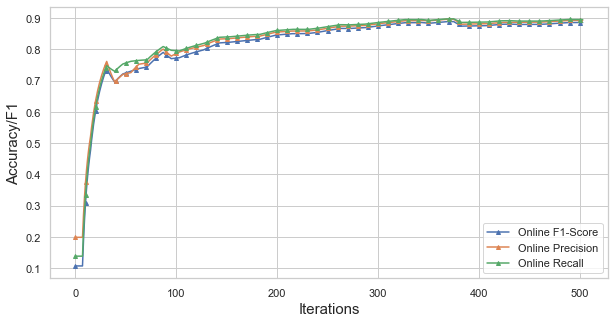

In [259]:
plt.figure(figsize=(10,5))
#plt.plot(values_dmfw[:,0][:-1],average_loss(values_dmfw[:,3][:-1]), label='Online Accuracy', marker='^', markersize=4,
#         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.plot(values_dmfw[:,0][:-1],average_loss(values_dmfw[:,4][:-1]), label='Online F1-Score', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.plot(values_dmfw[:,0][:-1],average_loss(values_dmfw[:,5][:-1]), label='Online Precision', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.plot(values_dmfw[:,0][:-1],average_loss(values_dmfw[:,6][:-1]), label='Online Recall', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.legend(loc='lower right')
#plt.yscale("log")
plt.xlabel("Iterations",fontsize=15)
plt.ylabel("Accuracy/F1",fontsize=15)

Text(0, 0.5, 'Loss')

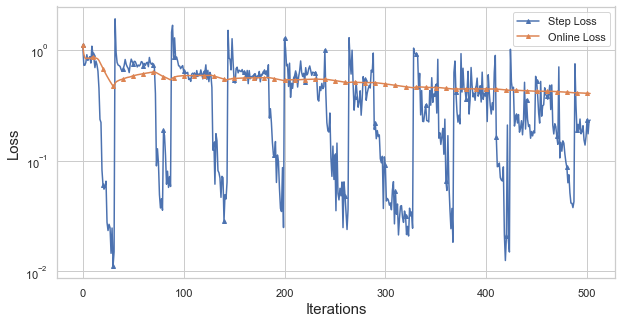

In [217]:
plt.figure(figsize=(10,5))
plt.plot(values_dmfw[:,0][:-1],values_dmfw[:,1][:-1], label='Step Loss', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.plot(values_dmfw[:,0][:-1],average_loss(values_dmfw[:,1][:-1]), label='Online Loss', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.axhline(y=0, color='grey', linestyle='--')
plt.legend(loc='upper right')
plt.yscale("log")
plt.xlabel("Iterations",fontsize=15)
plt.ylabel("Loss",fontsize=15)

In [218]:
def prediction(model, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print("Accuracy : {} {}".format(100 * correct/total, "%"))

In [358]:
def ModelPrediction(model_to_test, date ,loader):
    correct = 0
    total = 0
    f1 = 0
    true_array = []
    pred_array = []
    model_to_test.eval()
    with torch.no_grad():
        for series, label in loader[date]:
            outputs = model_to_test(series)
            _, predicted = torch.max(outputs,1)
            '''
            print("------------------------")
            print(f'Label {label}')
            print(f'Prediction {predicted}')
            print(f'Correct Prediction {(predicted == label).sum().item()}')
            print("-------------------------")'''
            total += label.size(0)
            correct += (predicted == label).sum().item()
            true_array.append(label.detach().numpy())
            pred_array.append(predicted.detach().numpy())
            
        truth_roll = np.asarray(true_array).flatten()
        pred_roll = np.asarray(pred_array).flatten()
        
        #series_truth_roll = []
        #series_pred_roll = []
        #for t,p in zip(truth_roll, pred_roll):
        #    series_truth_roll.append([t]*seq_len)
        #    series_pred_roll.append([p]*seq_len)
        #series_truth_roll = np.asarray(series_truth_roll).flatten()
        #series_pred_roll = np.asarray(series_pred_roll).flatten()
        
        #truth_reconstruct = np.asarray(true_array)[::seq_len].flatten()
        #pred_reconstruct = np.asarray(pred_array)[::seq_len].flatten()
        
        f1 = f1_score(truth_roll, pred_roll, average='weighted')
        precision = precision_score(truth_roll, pred_roll, average='weighted')
        recall = recall_score(truth_roll, pred_roll, average='weighted')
        conf_mat = confusion_matrix(truth_roll, pred_roll)
        #print(true_array.shape)
        accuracy = correct/total
        print(classification_report(truth_roll, pred_roll))
    return accuracy, f1 , precision, recall, conf_mat, truth_roll, pred_roll

In [359]:
date_acc, date_f1, date_prec, date_rec, conf_mat, true, pred = ModelPrediction(trainXMFW.best_models[model_idx], test_date[i], testloader[model_idx])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       256

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



In [360]:
len(test_date)

237

In [395]:
test_acc = []
test_f1 = []
test_prec = []
test_rec = []
prediction = []
truth = []
model_idx = 2
for i in range(20):
    print(f'-----{test_date[i]}-----')
    date_acc, date_f1, date_prec, date_rec, conf_mat, true, pred = ModelPrediction(trainXMFW.best_models[model_idx], test_date[i], testloader[model_idx])
    conf_mat = pd.DataFrame(conf_mat)
    #plt.figure()
    #sns.heatmap(conf_mat, annot=True)
    #plt.figure()
    #sns.heatmap(conf_mat, annot_kws={"size": 15})
    test_acc.append(date_acc)
    test_f1.append(date_f1)
    test_prec.append(date_prec)
    test_rec.append(date_rec)
    truth.append(true)
    prediction.append(pred)

-----2019-05-09-----
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       229
           2       0.81      0.96      0.88        27

    accuracy                           0.97       256
   macro avg       0.90      0.97      0.93       256
weighted avg       0.98      0.97      0.97       256

-----2019-05-10-----
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       160
           2       0.93      0.93      0.93        96

    accuracy                           0.95       256
   macro avg       0.94      0.94      0.94       256
weighted avg       0.95      0.95      0.95       256

-----2019-05-11-----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       256

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

-----2019-

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

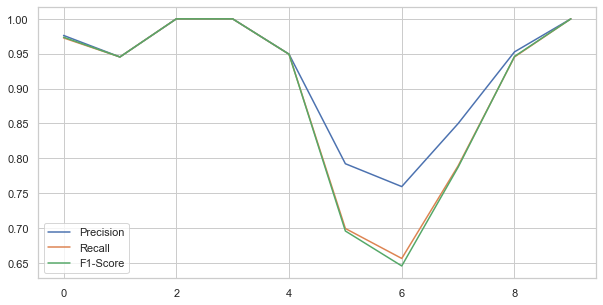

In [387]:
plt.figure(figsize=(10,5))
plt.plot(test_prec, label='Precision')
plt.plot(test_rec, label='Recall')
plt.plot(test_f1, label='F1-Score')
plt.legend()

In [396]:
hehe = test_date[:20]

In [397]:
real = resample_data_classes['Floor7Z1'].loc[resample_data_classes['Floor7Z1'].apply(lambda x: x.date in hehe, axis=1)]

In [398]:
real['ACPower']

Date
2019-05-09 00:00:00    0.05
2019-05-09 00:05:00    0.05
2019-05-09 00:10:00    0.05
2019-05-09 00:15:00    0.05
2019-05-09 00:20:00    0.05
                       ... 
2019-05-28 23:35:00    0.10
2019-05-28 23:40:00    0.10
2019-05-28 23:45:00    0.10
2019-05-28 23:50:00    0.10
2019-05-28 23:55:00    0.10
Freq: 5T, Name: ACPower, Length: 5760, dtype: float64

<AxesSubplot:xlabel='Date'>

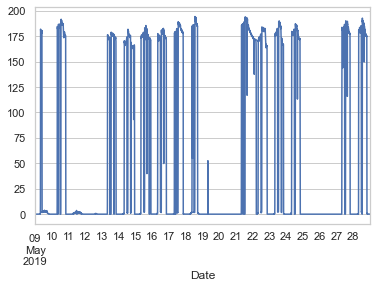

In [399]:
real['ACPower'].plot()

In [400]:
truetrue = np.asarray(truth).flatten()
predpred = np.asarray(prediction).flatten()

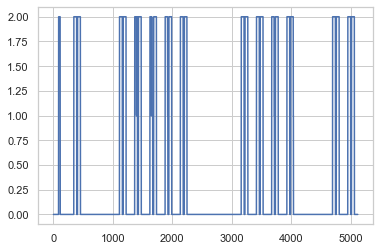

In [401]:
plt.plot(np.asarray(truth).flatten())

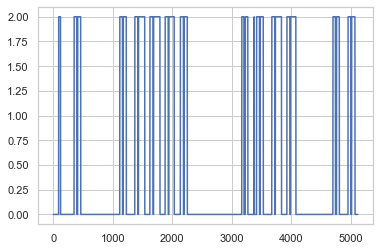

In [402]:
plt.plot(np.asarray(prediction).flatten())

8pm to 8am check data and validation
lunch time check